Make logistic regression

In [1]:
# Imports:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import dxchange
import nibabel as nib
import tifffile
from skimage.filters import threshold_otsu
import localthickness as lt
import json
import pandas as pd
import sklearn as sk
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.inspection import permutation_importance
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

os.chdir('/dtu/3d-imaging-center/courses/02509/groups/members/s194333/HPC3D_project')

astropy module not found


In [3]:
# set path to the folder containing the data
folder_path = '/dtu/3d-imaging-center/courses/02509/groups/group01/statistics/'

# Load the data frame
df = pd.read_csv(os.path.join(folder_path, 'statistics_sample_4.csv'))

In [4]:
# inspect the data frame
print(df.head())

      ratio  mean_thickness_stone  mean_thickness_bubbles  \
0  0.523256              0.901231                0.782770   
1  0.560037              1.059370                0.877167   
2  0.422924              0.455665                0.757389   
3  0.854188              1.745601                0.660797   
4  0.794132              1.910156                0.773452   

   median_thickness_stone  median_thickness_bubbles  max_thickness_stone  \
0                0.687883                  0.818935             1.969364   
1                1.032160                  0.835859             2.001981   
2                0.432289                  0.745323             0.823497   
3                2.047470                  0.653306             2.175269   
4                1.960630                  0.768611             2.745145   

   max_thickness_bubbles  var_thickness_stone  var_thickness_bubbles label  
0               1.228287             0.311715               0.050499    ny  
1               1.4449

In [5]:
# Define the features and the target
#X = df[['ratio', 'mean_thickness_stone', 'mean_thickness_bubbles', 'max_thickness_stone', 'max_thickness_bubbles', 'var_thickness_stone', 'var_thickness_bubbles']] # all features
X = df[['ratio', 'mean_thickness_stone', 'mean_thickness_bubbles']] # selected features
y = df['label']

In [6]:
# equal amout of training data for each class
# get the index of the three classes
idx_0 = df[df['label'] == 'gl'].index
idx_1 = df[df['label'] == 'ma'].index
idx_2 = df[df['label'] == 'ny'].index

# get the same amount of data for each class
num_train_0 = int(len(idx_0)*0.8)
num_train_1 = int(len(idx_1)*0.8)
num_train_2 = int(len(idx_2)*0.8)

# set a seed for reproducibility
np.random.seed(42)

# Loop over the number of repetitions
precision = 0
recall = 0
num_reps = 1000
for i in range(num_reps):
    # Get the indices for training and test set
    # Train data
    idx_train_0 = np.random.choice(idx_0, num_train_0, replace=False)
    idx_train_1 = np.random.choice(idx_1, num_train_1, replace=False)
    idx_train_2 = np.random.choice(idx_2, num_train_2, replace=False)

    # Test data
    idx_test_0 = np.setdiff1d(idx_0, idx_train_0)
    idx_test_1 = np.setdiff1d(idx_1, idx_train_1)
    idx_test_2 = np.setdiff1d(idx_2, idx_train_2)

    # Combine the indices
    idx_train = np.concatenate([idx_train_0, idx_train_1, idx_train_2])
    idx_test = np.concatenate([idx_test_0, idx_test_1, idx_test_2])
    
    # Split the data into training and test set
    X_train = X.loc[idx_train]
    X_test = X.loc[idx_test]
    y_train = y.loc[idx_train]
    y_test = y.loc[idx_test]

    # Normalize the data
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # Fit the model
    clf = LogisticRegression(random_state=0).fit(X_train, y_train)
    model_fi = permutation_importance(clf, X_train, y_train)
    try:
        importances += model_fi['importances_mean']
    except:
        importances = model_fi['importances_mean']    

    # Predict the test set
    y_pred = clf.predict(X_test)

    # Evaluate the model
    try:
        cm_all += confusion_matrix(y_test, y_pred)
    except:
        cm_all = confusion_matrix(y_test, y_pred)
    
    # Calculate precision and recall
    p, r, _, _ = sk.metrics.precision_recall_fscore_support(y_test, y_pred)
    precision += p
    recall += r

# Calculate the metrics
cm_all = cm_all/num_reps
precision = precision/num_reps
recall = recall/num_reps
importances = importances/num_reps

# round to int
cm_all = np.round(cm_all).astype(int)

# Print the results
print("The confusion matrix is: ")
print(cm_all)
print("The precision is: ", precision)
print("The recall is: ", recall)

# Print the mean values
print("The mean precision is: ", precision.mean())
print("The mean recall is: ", recall.mean())

# Print the feature importances
print("The feature importances are: ")
print(importances)

The confusion matrix is: 
[[40  0  0]
 [ 0 47  1]
 [ 1  2  2]]
The precision is:  [0.98638939 0.96075956 0.80217937]
The recall is:  [1.        0.9870625 0.4946   ]
The mean precision is:  0.9164427736122484
The mean recall is:  0.8272208333333321
The feature importances are: 
[0.18953571 0.41662198 0.09425879]


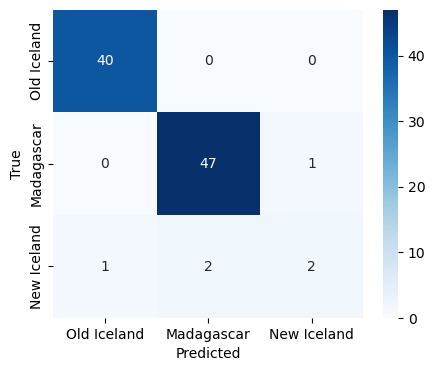

In [6]:
# Plot the confusion matrix
class_names = ['Old Iceland', 'Madagascar', 'New Iceland']
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(cm_all, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
# save the confusion matrix
fig.savefig('plots/confusion_matrix_all.png')

In [7]:
# equal amout of training data for each class
# get the index of the three classes
idx_0 = df[df['label'] == 'gl'].index
idx_1 = df[df['label'] == 'ma'].index
idx_2 = df[df['label'] == 'ny'].index

# get the same amount of data for each class
num_samples = len(idx_2)
num_samples_train = int(num_samples*0.8)

precision = 0
recall = 0
# Loop over the number of repetitions
for i in range(num_reps):
    idx_0 = np.random.choice(idx_0, num_samples, replace=False)
    idx_1 = np.random.choice(idx_1, num_samples, replace=False)
    #idx_2 = np.random.choice(idx_2, num_samples, replace=False)

    # concatenate the indices
    df_balanced = df.loc[np.concatenate([idx_0, idx_1, idx_2])]

    # Split the data into training and test set with equal amount of data for each class
    # train data
    idx_train_0 = np.random.choice(idx_0, num_samples_train, replace=False)
    idx_train_1 = np.random.choice(idx_1, num_samples_train, replace=False)
    idx_train_2 = np.random.choice(idx_2, num_samples_train, replace=False)

    # test data
    idx_test_0 = np.setdiff1d(idx_0, idx_train_0)
    idx_test_1 = np.setdiff1d(idx_1, idx_train_1)
    idx_test_2 = np.setdiff1d(idx_2, idx_train_2)

    # combine the indices
    idx_train = np.concatenate([idx_train_0, idx_train_1, idx_train_2])
    idx_test = np.concatenate([idx_test_0, idx_test_1, idx_test_2])

    X_train = X.loc[idx_train]
    X_test = X.loc[idx_test]
    y_train = y.loc[idx_train]
    y_test = y.loc[idx_test]

    # Normalize the data
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # Fit the model
    clf = LogisticRegression(random_state=0).fit(X_train, y_train)
    model_fi = permutation_importance(clf, X_train, y_train)
    try:
        importances += model_fi['importances_mean']
    except:
        importances = model_fi['importances_mean']    

    # Predict the test set
    y_pred = clf.predict(X_test)

    # Evaluate the model
    try:
        cm_eq += confusion_matrix(y_test, y_pred)
    except:
        cm_eq = confusion_matrix(y_test, y_pred)
    
    p, r, _, _ = sk.metrics.precision_recall_fscore_support(y_test, y_pred)
    precision += p
    recall += r

# Calculate the metrics
cm_eq= cm_eq/num_reps
cm_eq = np.round(cm_eq).astype(int) # round to int

precision = precision/num_reps
recall = recall/num_reps
importances = importances/num_reps

# Print the results
print("The confusion matrix is: ")
print(cm_eq)
print("The precision is: ", precision)
print("The recall is: ", recall)

# Print the mean values
print("The mean precision is: ", precision.mean())
print("The mean recall is: ", recall.mean())

# Print the feature importances
print("The feature importances are: ")
print(importances)

The confusion matrix is: 
[[5 0 0]
 [0 5 0]
 [1 0 4]]
The precision is:  [0.91987976 0.96985833 0.94112619]
The recall is:  [0.9994 0.935  0.8644]
The mean precision is:  0.9436214285714303
The mean recall is:  0.9329333333333313
The feature importances are: 
[0.3714312  0.37276246 0.11857759]


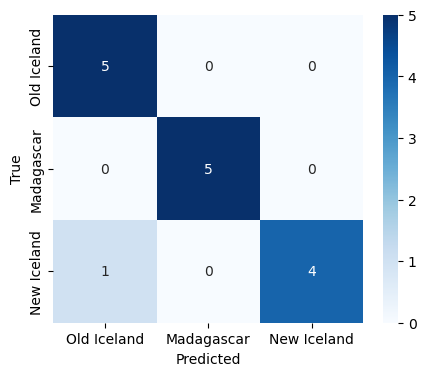

In [8]:
# Plot the confusion matrix
class_names = ['Old Iceland', 'Madagascar', 'New Iceland']
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(cm_eq, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
# save the confusion matrix
fig.savefig('plots/confusion_matrix_equal.png')

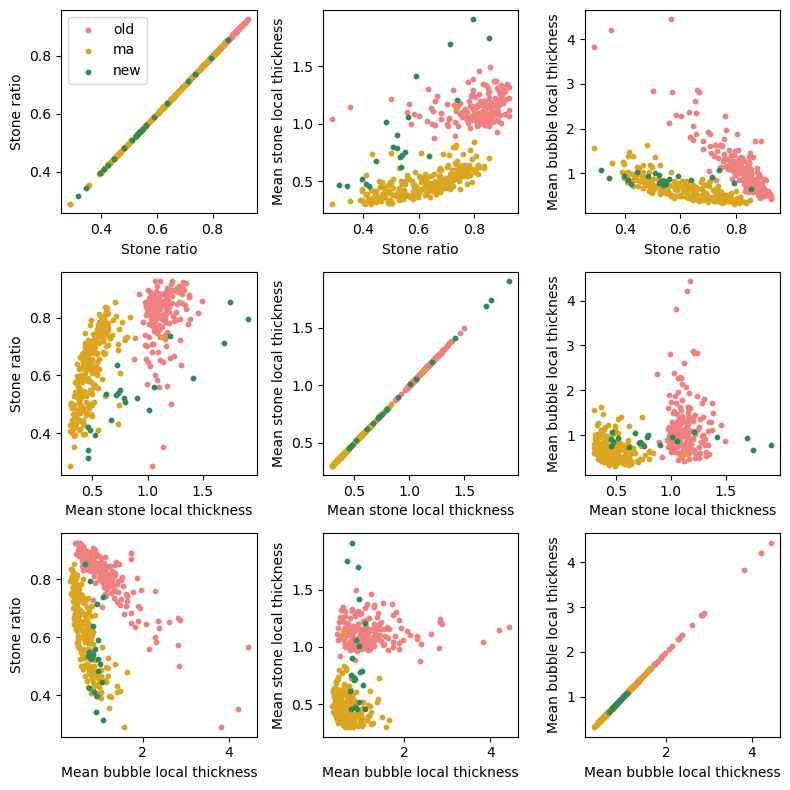

In [9]:
# Extract the features

# Island ny
ratios_ny = df[df['label'] == 'ny']['ratio']
mean_thickness_stone_ny = df[df['label'] == 'ny']['mean_thickness_stone']
mean_thickness_bubbles_ny = df[df['label'] == 'ny']['mean_thickness_bubbles']

# Island gl
ratios_gl = df[df['label'] == 'gl']['ratio']
mean_thickness_stone_gl = df[df['label'] == 'gl']['mean_thickness_stone']
mean_thickness_bubbles_gl = df[df['label'] == 'gl']['mean_thickness_bubbles']

# Madagascar stone
ratios_ma = df[df['label'] == 'ma']['ratio']
mean_thickness_stone_ma = df[df['label'] == 'ma']['mean_thickness_stone']
mean_thickness_bubbles_ma = df[df['label'] == 'ma']['mean_thickness_bubbles']

# Concatenate the features
stats_ny = [ratios_ny, mean_thickness_stone_ny, mean_thickness_bubbles_ny]
stats_gl = [ratios_gl, mean_thickness_stone_gl, mean_thickness_bubbles_gl]
stats_ma = [ratios_ma, mean_thickness_stone_ma, mean_thickness_bubbles_ma]

# Define labels
labels = ['Stone ratio', 'Mean stone local thickness', 'Mean bubble local thickness']

# plot the feature matrix
fig, ax = plt.subplots(len(stats_ny), len(stats_ny), figsize=(8, 8))
for i in range(len(stats_ny)):
    for j in range(len(stats_ny)):
        # change the marker size
        ax[i, j].scatter(stats_gl[i], stats_gl[j], label='old', color='lightcoral', s=10)
        ax[i, j].scatter(stats_ma[i], stats_ma[j], label='ma', color='goldenrod', s=10)
        ax[i, j].scatter(stats_ny[i], stats_ny[j], label='new', color='seagreen', s=10)
        ax[i, j].set_xlabel(labels[i])
        ax[i, j].set_ylabel(labels[j])
        if i == 0 and j == 0:
            ax[i, j].legend()
plt.tight_layout()
plt.show()

# save the figure
fig.savefig('plots/correlation_matrix.png')

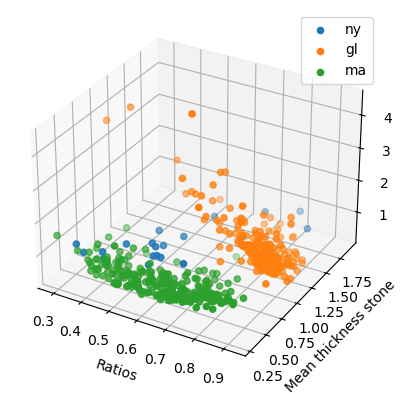

In [10]:
# make 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ratios_ny, mean_thickness_stone_ny, mean_thickness_bubbles_ny, label='ny')
ax.scatter(ratios_gl, mean_thickness_stone_gl, mean_thickness_bubbles_gl, label='gl')
ax.scatter(ratios_ma, mean_thickness_stone_ma, mean_thickness_bubbles_ma, label='ma')
ax.set_xlabel('Ratios')
ax.set_ylabel('Mean thickness stone')
ax.set_zlabel('Mean thickness bubbles')
plt.legend()
plt.show()
